In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
from imblearn.over_sampling import SMOTE
#%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold

from scipy.stats import norm
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#DS
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#KNN
from sklearn.neighbors import KNeighborsClassifier

#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

#LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV

#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 1. Loading the dataset

In [3]:
#loading the data from CSV file 
data=pd.read_csv('final_Binary.csv')
data.head()

'''dataFeatures= ['Side Chest Airbag-Driver', 'Side Chest Airbag-Passenger',
       'AEB Vulnerable Road Users', 'Side Head Airbag-Driver',
       'Side Head Airbag-Passenger', 'Seatbelt Reminder-Passenger',
       'AEB Car-to-Car', 'Belt Loadlimiter-Rear', 'Belt Pretensioner-Rear',
       'Side Head Airbag-Rear', 'Lane Assist System', 'Seatbelt Reminder-Rear',
       'Safety Assist', 'Speed Assistance', 'Adult Occupant',
       'Centre Airbag-Driver', 'Child Occupant', 'Tested Model',
       'Isofix/i-Size-Passenger'] '''

dataFeatures= ['Adult Occupant', 'Belt Pretensioner-Rear', 'Safety Assist',
       'Child Occupant', 'Class', 'Side Pelvis Airbag-Rear',
       'AEB Vulnerable Road Users']


In [4]:
# print the columns in the dataset
data.columns

Index(['Adult Occupant', 'Belt Pretensioner-Rear', 'Safety Assist',
       'Child Occupant', 'Class', 'Side Pelvis Airbag-Rear',
       'AEB Vulnerable Road Users', 'Rate'],
      dtype='object')

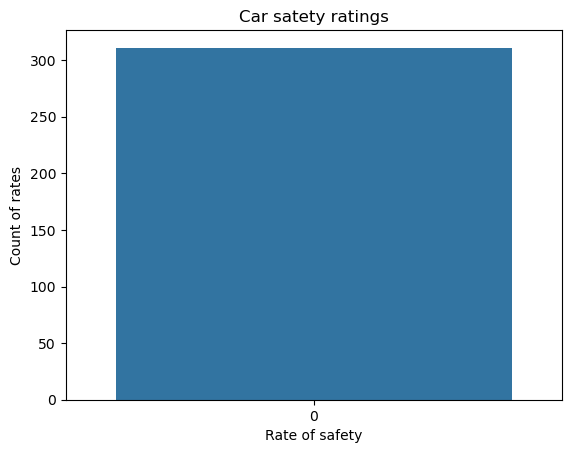

In [5]:
#Data presentation 

sns.countplot(data["Rate"])
plt.xlabel("Rate of safety")
plt.ylabel("Count of rates")
plt.title("Car satety ratings")
plt.show()

In [6]:
'''# Create a MinMaxScaler object for numrical data
scaler = MinMaxScaler()

# Scaling the raw input features 
feature_cols=data.columns[:-1]
X= scaler.fit_transform(data[feature_cols])

print(f"The range of feature inputs are within {X.min()} to {X.max()}")'''

'# Create a MinMaxScaler object for numrical data\nscaler = MinMaxScaler()\n\n# Scaling the raw input features \nfeature_cols=data.columns[:-1]\nX= scaler.fit_transform(data[feature_cols])\n\nprint(f"The range of feature inputs are within {X.min()} to {X.max()}")'

## 2. Split the dataset 

In [7]:

from sklearn.model_selection import StratifiedShuffleSplit

feature_cols=data.columns[:-1]
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, random_state=0)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data['Rate']))

# Create the dataframes


X_train = data.loc[train_idx, dataFeatures]
y_train = data.loc[train_idx, 'Rate']

X_test  = data.loc[test_idx, dataFeatures]
y_test  = data.loc[test_idx, 'Rate']

print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (217, 7), y_train: (217,)
Testing dataset shape, X_test: (94, 7), y_test: (94,)


## 3. Smoot 

In [22]:
X= data.loc[:,dataFeatures]
y= data.loc[:,["Rate"]]

def splitSmote (model):
    # Initialize the Stratified K-fold Cross-validator with 5 splits
    sk=StratifiedKFold(n_splits=5)

    # Initialize the array to store the accuracy scores
    tr_accuracy_scores = []
    tst_accuracy_scores = []

    # Perform cross-validation
    for train_index, test_index in sk.split(X, y):
        # Split the data into training and test sets
        x_train_fold, x_test_fold = X.loc[train_index,:], X.loc[test_index,:]
        y_train_fold, y_test_fold = y.loc[train_index,:], y.loc[test_index,:]

        smote = SMOTE(sampling_strategy='minority')
        # smote = SMOTE(sampling_strategy=0.5)
        x_sm, y_sm = smote.fit_resample(x_train_fold, y_train_fold)
        #Fit the model to the training data
        model.fit(x_sm, np.ravel(y_sm))
        # Make predictions on the test data
        yTrain_pred = model.predict(x_train_fold)
        yTest_pred = model.predict(x_test_fold)

        # Calculate the accuracy score and append it to the list
        tr_accuracy_scores.append(accuracy_score(y_train_fold, yTrain_pred))
        tst_accuracy_scores.append(accuracy_score(y_test_fold, yTest_pred))
        #Data presentation 

        print("before smote")
        sns.countplot(y_train_fold["Rate"])
        plt.xlabel("Rate of safety")
        plt.ylabel("Count of rates")
        plt.title("Car satety ratings")
        plt.show()

        print("after smote")
        sns.countplot(y_sm["Rate"])
        plt.xlabel("Rate of safety")
        plt.ylabel("Count of rates")
        plt.title("Car satety ratings")
        plt.show()




    # Print the accuracy scores for each fold
    print("Accuracy scores for each training fold: ", tr_accuracy_scores)
    print("Accuracy scores for each testing fold: ", tst_accuracy_scores)

    # Calculate the mean accuracy scores
    print("Traning Mean accuracy score: ", np.mean(tr_accuracy_scores))
    print("Testing Mean accuracy score: ", np.mean(tst_accuracy_scores))

## 4. Data normalization 

In [9]:
y_train.value_counts(normalize=True)

1    0.718894
0    0.281106
Name: Rate, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

1    0.723404
0    0.276596
Name: Rate, dtype: float64

## 4. Models 

### 4.1 Decision Tree 

before optimization

In [11]:
# DecisionTreeClassifier
#importing the classfier
metrics=[]

clf=DecisionTreeClassifier(random_state=0)
#clf2=clf.fit(X_train,y_train)


#y_pred.append(pd.Series(clf2.predict(X_test), name='DecisionTreeClassifier'))
# Preciision, recall, f-score from the multi-class support function

# precision, recall, fscore, _ = score(y_test, clf2.predict(X_test), average='weighted')
# accuracy = accuracy_score(y_test, clf2.predict(X_test))
# metrics.append(pd.Series({'precision':precision, 'recall':recall,'fscore':fscore, 'accuracy':accuracy}))


splitSmote (clf)

before smote


KeyError: 0

After optimization

In [12]:
# DecisionTree opt


#optimization
param_grid={
"max_depth":[2,4,6],
"min_samples_split":[2,5,10],
"min_samples_leaf":[1,2,4]}
grid_search= GridSearchCV(estimator=clf,param_grid=param_grid,cv=5)

# grid_search.fit(X_train,y_train)
# print("Best hyper-param: ",grid_search.best_params_ )
# print("Best estimator: ",grid_search.best_estimator_ )
# print("Best score: ",grid_search.best_score_ )


# #precision, recall, fscore, _ = score(y_test, grid_search.predict(X_test), average='weighted')
# accuracy = accuracy_score(y_test, grid_search.predict(X_test))
# metrics.append(pd.Series({'precision':precision, 'recall':recall,'fscore':fscore, 'accuracy':accuracy}))


#splitSmote (kCls)

In [13]:
#DT aftar opt

print("grid_search")

splitSmote(grid_search)

grid_search
before smote


KeyError: 0

### 4.2 KNN

Before optimization

In [14]:
# KNN
#importing the classfier

kCls=KNeighborsClassifier()
splitSmote (kCls)
#kCls.fit(X_train,y_train)

#y_pred.append(pd.Series(kCls.predict(X_test), name='KNeighborsClassifier'))

#precision, recall, fscore, _ = score(y_test, kCls.predict(X_test), average='weighted')
#accuracy = accuracy_score(y_test, kCls.predict(X_test))
#metrics.append(pd.Series({'precision':precision, 'recall':recall,'fscore':fscore, 'accuracy':accuracy}))

#kCls=KNeighborsClassifier(n_neighbors=9)


before smote


KeyError: 0

After optimization

In [15]:
#KNN after Optimization 

kCls=KNeighborsClassifier(algorithm="brute")
splitSmote (kCls)


### 4.3 GradientBoosting

Before optimization

In [16]:
# GradientBoostingClassifier
#importing the classfier

gb_clf = GradientBoostingClassifier()
splitSmote(gb_clf)


before smote


KeyError: 0

After optimization

In [17]:
# # optimizing the GradientBoostingClassifier using RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators' : [20,50,70,100], 
                'learning_rate' : [0.01, 0.02, 0.03, 0.04], 
                'max_depth' : [4,6,8,10],
                'subsample' : [0.9, 0.7 ,0.5 , 0.2 ],
                'max_features' :[3,5,7]
                }

grid = GridSearchCV(estimator= gb_clf, 
                    param_grid= parameters, 
                    cv= 2,
                    n_jobs= -1)


grid.fit(X_train, y_train)
splitSmote(grid)





KeyboardInterrupt: 

In [ ]:
# print(grid.best_estimator_)
# print(grid.best_score_)
# print(grid.best_params_)
# print(grid.cv_results_)

GradientBoostingClassifier(learning_rate=0.03, max_depth=10, max_features=7,
                           n_estimators=50, subsample=0.5)
0.9555555555555555
{'learning_rate': 0.03, 'max_depth': 10, 'max_features': 7, 'n_estimators': 50, 'subsample': 0.5}
{'mean_fit_time': array([0.03366113, 0.03366113, 0.03366137, 0.03282058, 0.08698392,
       0.09165919, 0.08392   , 0.10865557, 0.1333636 , 0.12502873,
       0.18311083, 0.1080035 , 0.22033167, 0.21404874, 0.21664703,
       0.15798306, 0.04161191, 0.03761387, 0.03843236, 0.03364956,
       0.08798349, 0.08682549, 0.1039784 , 0.074736  , 0.1290133 ,
       0.1586473 , 0.1462847 , 0.13832605, 0.17935586, 0.18728554,
       0.17457378, 0.23766184, 0.03341353, 0.04157186, 0.06230128,
       0.03730798, 0.10393441, 0.07867301, 0.10792136, 0.07870579,
       0.15336263, 0.10895145, 0.11232948, 0.16425502, 0.16823101,
       0.18632019, 0.27920461, 0.24617243, 0.06559062, 0.07358515,
       0.07994664, 0.04796791, 0.21806026, 0.16100621, 0.18

In [18]:
opt_gb_clf = GradientBoostingClassifier(learning_rate=0.02, 
                                        max_depth= 6, 
                                        subsample=0.5, 
                                        n_estimators = 70, 
                                        max_features = 7)


opt_gb_clf.fit(X_train, y_train)
splitSmote(opt_gb_clf)

before smote


KeyError: 0

the best until now

learning_rate=0.03, 
                                        max_depth= 6, 
                                        subsample=0.5, 
                                        n_estimators = 50, 
                                        max_features = 7)

### 4.4 LogisticRegression

Before optimization

In [23]:
#TODO: write LogisticRegression optimization code here

logreg=LogisticRegression()
splitSmote (logreg)

LogisticRegression
before smote


KeyError: 0

After optimization

In [21]:
#LogisticRegression

#Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2","elasticnet"], 'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}
logreg=LogisticRegression()
lr=GridSearchCV(logreg,grid,cv=10)
# lr.fit(X_train,y_train)

# a=lr.best_params_
# b=lr.best_score_
# print("tuned hpyerparameters :(best parameters) ",lr.best_params_)
# print("accuracy :",lr.best_score_)
# print("Best estimator: ",lr.best_estimator_ )

#y_pred.append(pd.Series(lr.predict(X_test), name='LogisticRegression'))

# precision, recall, fscore, _ = score(y_test, lr.predict(X_test), average='weighted')
# accuracy = accuracy_score(y_test, lr.predict(X_test))
# metrics.append(pd.Series({'precision':precision, 'recall':recall,'fscore':fscore, 'accuracy':accuracy}))

#LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#lr= LogisticRegressionCV(Cs=a['C'], penalty=a['penalty'], solver=a['solver']).fit(X_train, y_train)

splitSmote (lr)

### 4.5 Random Forest

Before optimization

In [ ]:
#RandomForestClassifier
RF= RandomForestClassifier(random_state= 0)
# RF.fit(X_train,y_train)

# #y_pred.append(pd.Series(RF.predict(X_test), name='RandomForestClassifier'))

# precision, recall, fscore, _ = score(y_test, RF.predict(X_test), average='weighted')
# accuracy = accuracy_score(y_test, RF.predict(X_test))
# metrics.append(pd.Series({'precision':precision, 'recall':recall,'fscore':fscore, 'accuracy':accuracy}))


splitSmote (RF)

Accuracy scores for each training fold:  [1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy scores for each testing fold:  [0.9523809523809523, 1.0, 0.7903225806451613, 0.967741935483871, 0.7741935483870968]
Traning Mean accuracy score:  1.0
Testing Mean accuracy score:  0.8969278033794164


After optimization

In [ ]:
# #TODO: Write RandomForest optimization code here

# #RandomForest optimization
# random_grid={
# "max_depth":[2,4,6],
# "min_samples_split":[2,5,10],
# "min_samples_leaf":[1,2,4]}
# random_search= GridSearchCV(estimator=RF,param_grid=random_grid,cv=5)


# print("random_search")
# random_search.fit(X_train, y_train)
# splitSmote(random_search)


random_search


KeyboardInterrupt: 

In [ ]:
# #print(random_search.best_estimator_)
# print(random_search.best_score_)
# print(random_search.best_params_)
# print(random_search.cv_results_)

0.9407407407407407
{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5}
{'mean_fit_time': array([0.10915833, 0.10873075, 0.10442495, 0.10606613, 0.10393457,
       0.1043633 , 0.10886307, 0.11078372, 0.11789246, 0.11568594,
       0.11351151, 0.10705094, 0.10543561, 0.11611819, 0.10590014,
       0.10392418, 0.10913391, 0.10713654, 0.10808372, 0.10603871,
       0.10830426, 0.10976267, 0.10553489, 0.1068552 , 0.10562015,
       0.10437803, 0.10872912]), 'std_fit_time': array([3.45143893e-03, 3.92021144e-03, 1.02617642e-03, 3.10341403e-03,
       1.48566726e-05, 8.66248013e-04, 6.30879043e-03, 9.06395404e-03,
       5.92463911e-03, 1.45218046e-02, 5.98650097e-03, 4.61625434e-03,
       4.36142252e-03, 1.61829348e-02, 3.09842999e-03, 1.34283643e-05,
       3.46748557e-03, 3.92682770e-03, 3.28357460e-03, 3.09782790e-03,
       5.66847922e-03, 5.94912407e-03, 3.20990102e-03, 3.60520352e-03,
       3.15721474e-03, 8.79943959e-04, 3.93145805e-03]), 'mean_score_time': array([0.0080

## 5. Training

### 5.1 Before Optimazation 

In [ ]:
# Base models 
kCls=KNeighborsClassifier()
print("KNN")
splitSmote (kCls)

gb_clf2 = GradientBoostingClassifier()
print("GradientBoosting")
splitSmote (gb_clf2)

logreg=LogisticRegression()
print("LogisticRegression")
splitSmote (logreg)

RF= RandomForestClassifier()
print("RandomForest")
splitSmote (RF)

clf=DecisionTreeClassifier()
print("DecisionTree")
splitSmote (clf)






KNN
Accuracy scores for each fold:  [0.9365079365079365, 0.9193548387096774, 0.7903225806451613, 0.9516129032258065, 0.7741935483870968]
Mean accuracy score:  0.8743983614951356
GradientBoosting
Accuracy scores for each fold:  [0.9682539682539683, 1.0, 0.7903225806451613, 0.9838709677419355, 0.7419354838709677]
Mean accuracy score:  0.8968766001024064
LogisticRegression
Accuracy scores for each fold:  [0.9047619047619048, 1.0, 0.8225806451612904, 0.967741935483871, 0.6612903225806451]
Mean accuracy score:  0.8712749615975423
RandomForest


C:\Users\rayoo\AppData\Local\Temp\ipykernel_45220\3765096017.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_sm, y_sm)
C:\Users\rayoo\AppData\Local\Temp\ipykernel_45220\3765096017.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_sm, y_sm)
C:\Users\rayoo\AppData\Local\Temp\ipykernel_45220\3765096017.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_sm, y_sm)
C:\Users\rayoo\AppData\Local\Temp\ipykernel_45220\3765096017.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_sm, y_sm)


Accuracy scores for each fold:  [0.9523809523809523, 1.0, 0.7903225806451613, 0.967741935483871, 0.7741935483870968]
Mean accuracy score:  0.8969278033794164
DecisionTree
Accuracy scores for each fold:  [0.9841269841269841, 0.967741935483871, 0.7903225806451613, 0.9516129032258065, 0.7096774193548387]
Mean accuracy score:  0.8806963645673322


C:\Users\rayoo\AppData\Local\Temp\ipykernel_45220\3765096017.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_sm, y_sm)


### After Optimization

In [ ]:
#TODO: write the code here

## 5. Evaluation

### 5.1 Before Optimization

In [ ]:

def report( y_test, pred ):
    #report 
    print(classification_report(y_test,pred,target_names=['0','1','2','3','4','5']))


def confusionMatrix():
    #confusion_matrix
    #the result will show how mwny sucessful predition and wrong from each class

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(10,7))

    sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues')

    # TN   FP
    # FN   TP

In [ ]:
metrics = pd.concat(metrics, axis=1,names=['DecisionTree','DecisionTreeOpt','KNN','GradientBoosting','LogisticRegression','RandomForest'])


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [ ]:
metrics.columns=['DecisionTree','DecisionTreeOpt','KNN','GradientBoosting','LogisticRegression','RandomForest']
metrics

,DecisionTree,DecisionTreeOpt,KNN,GradientBoosting,LogisticRegression,RandomForest
precision,1.0,1.0,0.733490,0.963374,0.961147,0.944874
recall,1.0,1.0,0.776596,0.968085,0.968085,0.968085
fscore,1.0,1.0,0.749230,0.963933,0.962621,0.954647
accuracy,1.0,1.0,0.776596,0.968085,0.968085,0.968085


### 5.2 After Optimization

In [ ]:
#TODO: write the code here